In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import scipy
import astropy
import tqdm

## Load data

In [3]:
def data_scope(arr, t_arr, t_start, t_stop):
    idxs = np.where((t_arr >= t_start) & (t_arr <= t_stop))[0]
    return arr[idxs]

def spike_scope(spikes, t_arr):
    hists = []
    for spike_train in spikes.item().values():
        hist, _ = np.histogram(spike_train, bins=np.append(t_arr, t_arr[-1] + t_arr[1] - t_arr[0]))
        hists.append(hist)
    hists = np.array(hists)
    return hists

In [4]:
data_path = '/Users/vemundss/Desktop/Toroidal_topology_grid_cell_data/'

In [5]:
with open(data_path + 'rat_q_sessions.txt') as file:
#with open(data_path + 'rat_r_day1_sessions.txt') as file:
#with open(data_path + 'rat_r_day2_sessions.txt') as file:
#with open(data_path + 'rat_s_sessions.txt') as file:
    sessions = file.readlines()
sessions

['#1,  sleep_box_1,        start=9576, end=18812   \n',
 '#2,  wagon_wheel_1,      start=18977, end=25355   \n',
 '#3,  sleep_box_2,        start=25403, end=27007   \n',
 '#4,  open_field_1,       start=27826, end=31223   \n']

In [6]:
data = {}

In [7]:
f = np.load(data_path + 'rat_q_grid_modules_1_2.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']

t_start, t_stop = 27826, 31223
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)

data['rat_q'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2}}

In [8]:
f = np.load(data_path + 'rat_r_day1_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 7457, 14778
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day1'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

# can add second slice (valid times) 14890, 16045 here

In [9]:
f = np.load(data_path + 'rat_r_day2_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 10617, 13004
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day2'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

In [10]:
f = np.load(data_path + 'rat_s_grid_modules_1.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']

t_start, t_stop = 9939, 12363
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)

data['rat_s'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1}}

## Create ratemaps

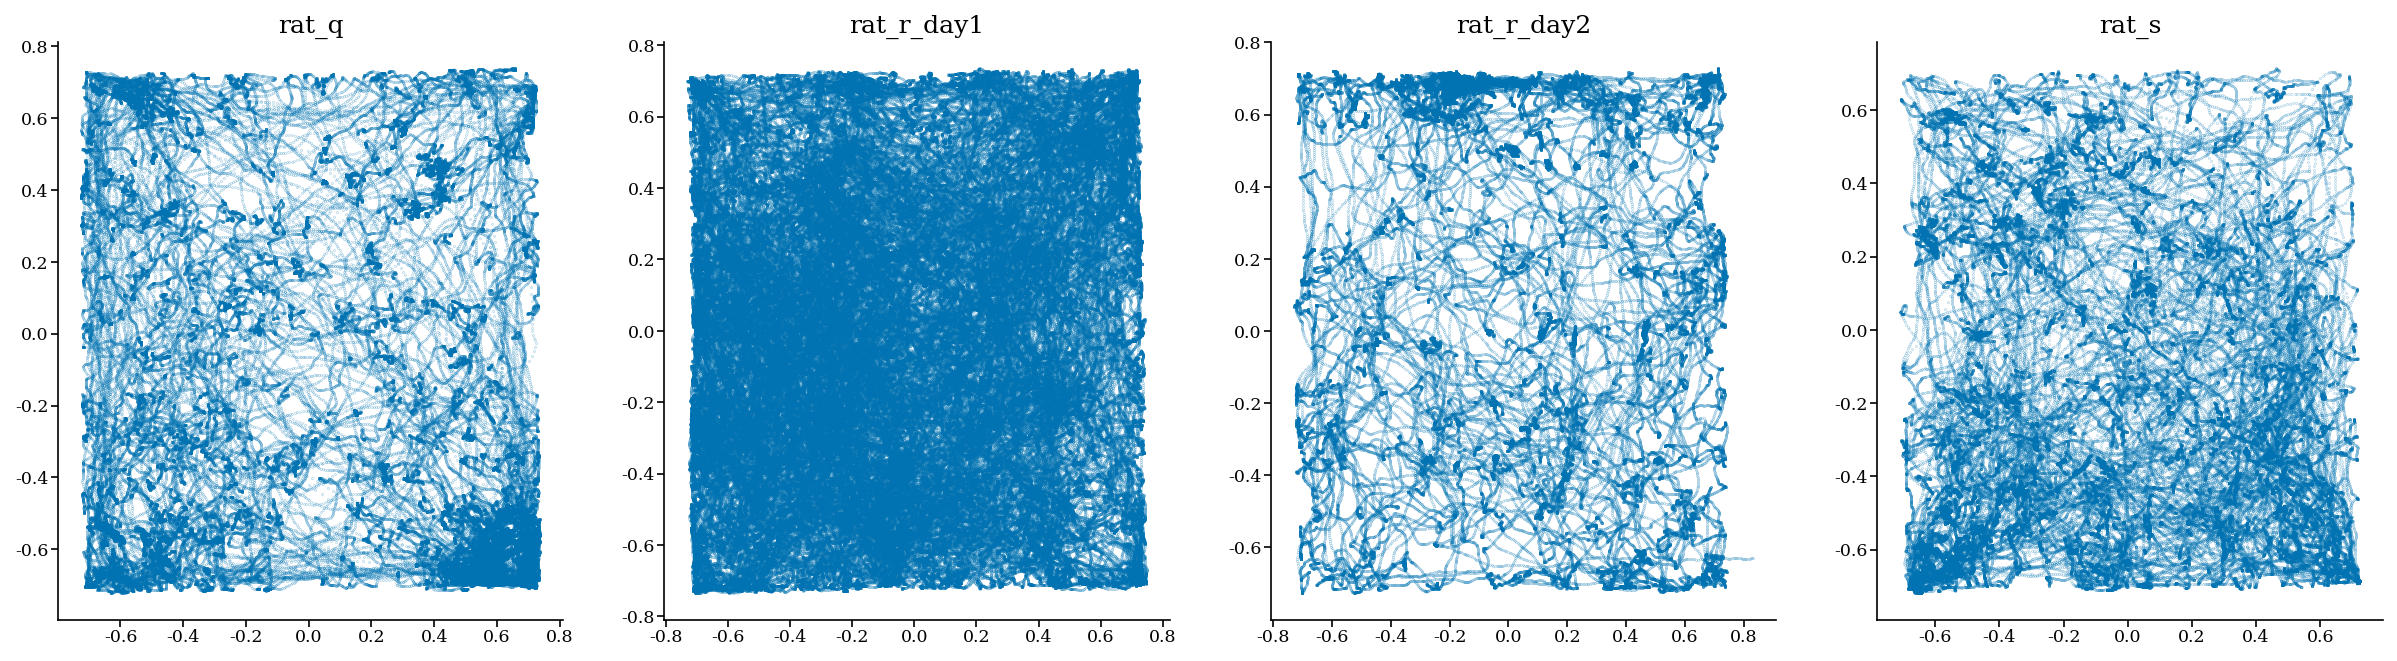

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
for i, (rat, rat_data) in enumerate(data.items()):
    axs[i].scatter(rat_data['x'], rat_data['y'], s=0.01)
    axs[i].set_title(rat)

In [36]:
res = 32
all_ratemaps = []
for rat_i, data_i in data.items():
    x, y = data_i['x'], data_i['y']
    for module_j, spikes_j in data_i['modules'].items():
        ratemaps_ij = scipy.stats.binned_statistic_2d(x, y, spikes_j, bins=res).statistic
        all_ratemaps.append(ratemaps_ij)

## Calculate grid statistics

In [37]:
import spatial_maps as sm
grid_threshold = 0.4 # <----------------- threshold for gridness score
ratemaps = all_ratemaps[2] # <----------------- select grid module
ratemaps = np.array([astropy.convolution.convolve(ratemaps[i], astropy.convolution.Gaussian2DKernel(2), boundary='wrap') for i in range(ratemaps.shape[0])])

center_peaks = np.array([sm.find_peaks(ratemaps[i])[0] for i in range(ratemaps.shape[0])])
grid_scores = np.array([sm.gridness(ratemap) for ratemap in ratemaps])
acorrs = np.array([sm.autocorrelation(ratemap) for ratemap in ratemaps])
peaks = [sm.find_peaks(acorr) for acorr in acorrs]
thetas = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
# get the most common spacing and theta
bins=25
hist, bin_edges = np.histogram(spacings, bins=bins)
spacing = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2
hist, bin_edges = np.histogram(thetas, bins=bins)
theta = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2

from methods import Hexagon, HexagonalGCs
radius = spacing/np.sqrt(3) # spacing is peak-to-peak distance
orientation = theta*180/np.pi - 15 # theta is angle from x-axis
hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)

# mask out non-grid cells
mask = grid_scores > 0.5
mask = hexagon.unit_cell.is_in_hexagon(center_peaks-(res-1)/2) & mask
print("n=",(mask).sum(), ", N=",len(mask))

# remove stats based on phases outside hexagon and grid scores below threshold
center_peaks = center_peaks[mask]
ratemaps = ratemaps[mask]
thetas = thetas[mask]
spacings = spacings[mask]
grid_scores = grid_scores[mask]

hexagon.set_phases(center_peaks-(res-1)/2) # WRAPPY?
random_hexagon = HexagonalGCs(f=2/(3*radius), init_rot=orientation)
random_hexagon.set_phases(random_hexagon.unit_cell.wrap(np.around(random_hexagon.unit_cell.sample(len(center_peaks)))))
print(f"Radius: {radius}, Orientation: {orientation}")

n= 98 , N= 166
Radius: 7.102767803117688, Orientation: -7.130993247402021


Text(0.5, 1.0, 'Gridness')

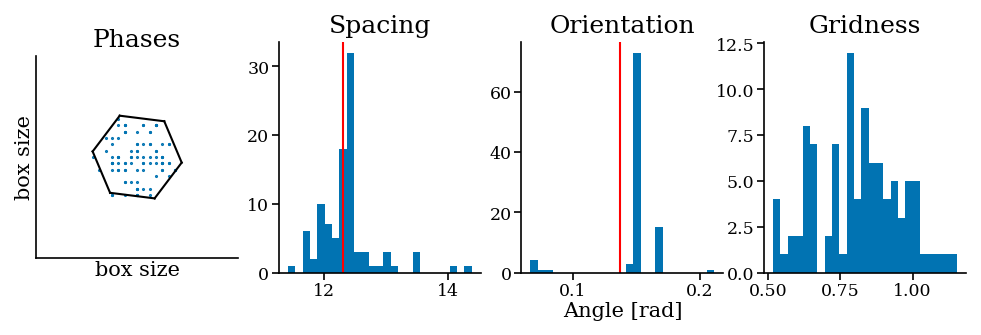

In [38]:
fig, axs = plt.subplots(ncols=4, figsize=(8, 2))
axs[0].scatter(*(center_peaks-res/2).T)
axs[0].set_xlim(-res/2, res/2)
axs[0].set_ylim(-res/2, res/2)
hexagon.unit_cell.plot(fig, axs[0], color='black')#, center=np.zeros(2)+res/2-1)
#ax.scatter(*(center_peaks-res/2).T, color='green', alpha=.2)
axs[0].set_title('Phases')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal')
axs[0].set_xlabel('box size')
axs[0].set_ylabel('box size')
axs[1].hist(spacings, bins=bins)
axs[1].axvline(spacing, color='r')
axs[1].set_title('Spacing')
axs[2].hist(thetas, bins=bins)
axs[2].axvline(theta, color='r')
axs[2].set_title('Orientation')
axs[2].set_xlabel('Angle [rad]')
axs[3].hist(grid_scores, bins=bins)
axs[3].set_title('Gridness')

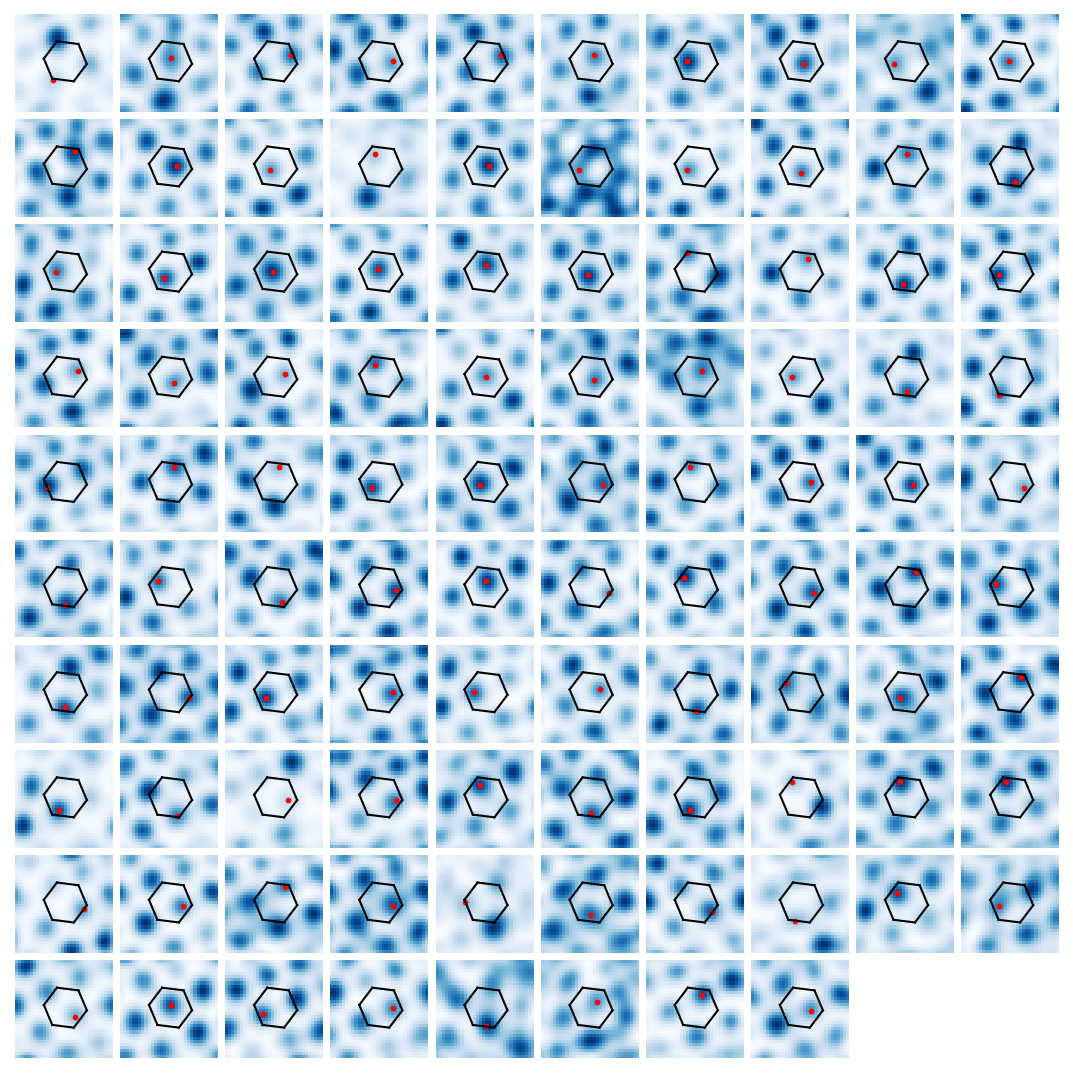

In [39]:
from plotting_functions import multiimshow
fig, axs = multiimshow(ratemaps[np.argsort(grid_scores)[::-1]].transpose(0,2,1), origin='lower', figsize=(8,8), normalize=False);
for i in range(len(center_peaks)):
    axs[i].scatter(*center_peaks[np.argsort(grid_scores)[::-1]][i], color='red', s=3)
    #hexagon.unit_cell.plot(fig, axs[i], center=center_peaks[np.argsort(grid_scores)[::-1]][i], color='black')
    hexagon.unit_cell.plot(fig, axs[i], center=np.ones(2)*res/2, color='black')

## KDE, Ripley and Grid score of phases

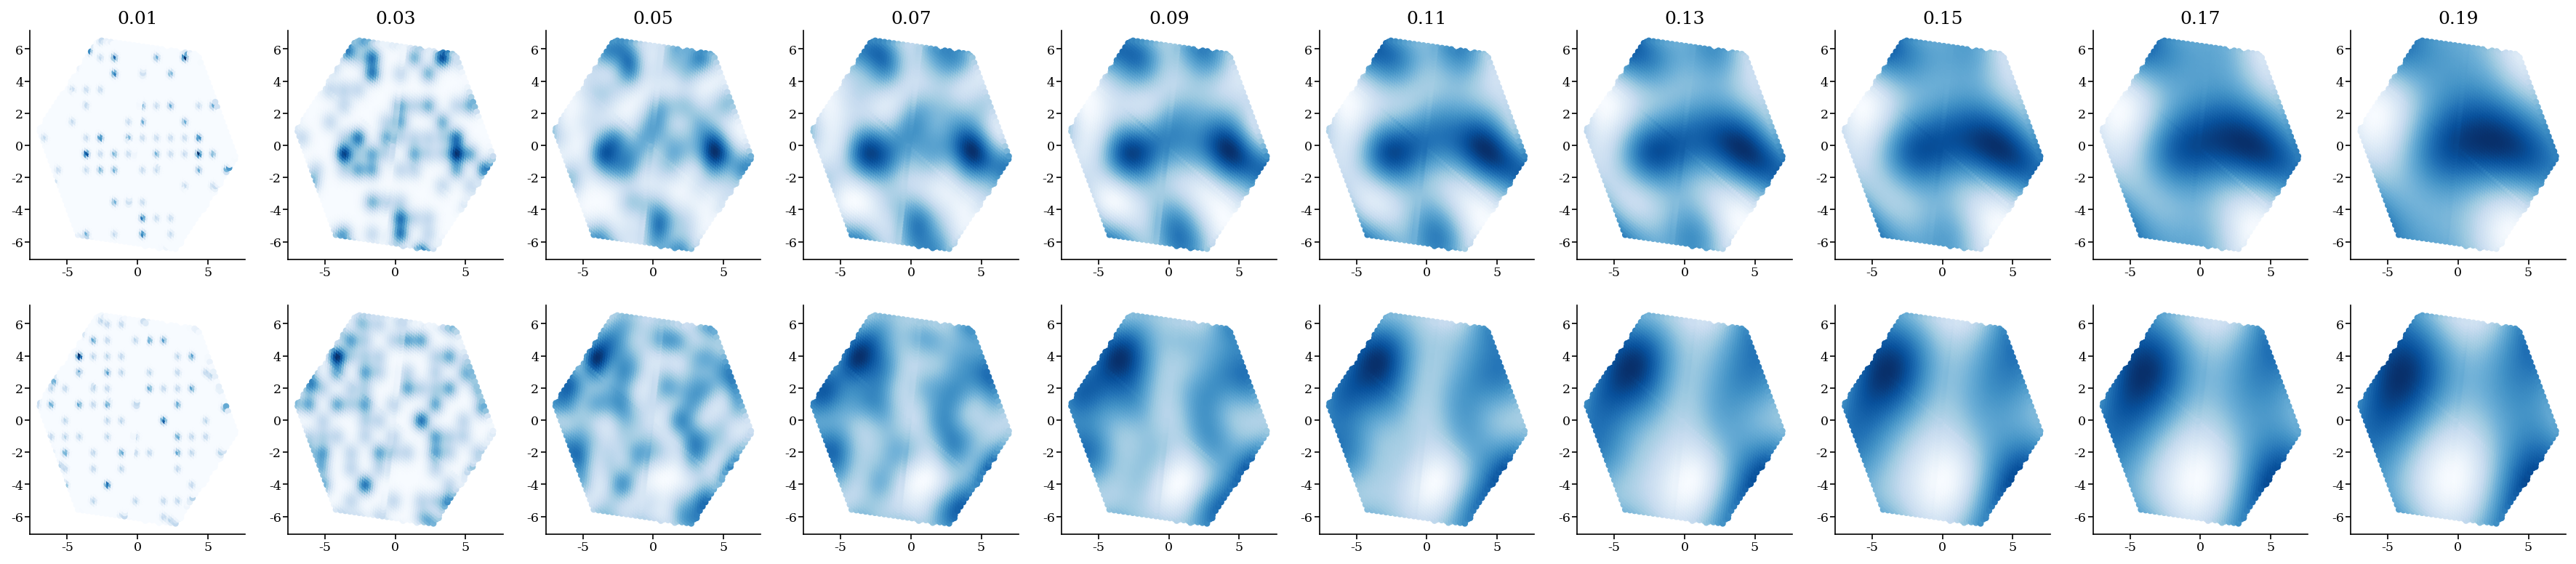

In [40]:
bw_method = np.linspace(0, 0.2, 21)[1:]#hexagon.unit_cell.radius/2/10, 21)[1:]
fig, axs = plt.subplots(nrows=2, ncols=len(bw_method)//2, figsize=(len(bw_method)//2*3, 3*2))
for i, r in enumerate(bw_method[::2]):
    kde, mesh, _, _ = hexagon.phase_kde(bw_method=r, res=64)
    axs[0,i].scatter(*mesh.T, c=kde, s=10)
    axs[0,i].set_title(f'{r:.2f}')


for i, r in enumerate(bw_method[::2]):
    kde, mesh, _, _ = random_hexagon.phase_kde(bw_method=r, res=64)
    axs[1,i].scatter(*mesh.T, c=kde, s=10)

Text(0.5, 1.0, '-0.02')

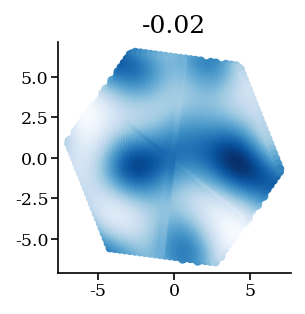

In [41]:
fig, ax = plt.subplots(figsize=(2,2))
kde, mesh, _, _ = hexagon.phase_kde(bw_method=0.11, res=64)#,wrap=False,double_extension=False)
phase_grid_score = hexagon.grid_score(bw_method=0.11)
ax.scatter(*mesh.T, c=kde, s=10)
ax.set_title(f'{phase_grid_score:.2f}')

In [42]:
from models import JacobianCI
ci_model = JacobianCI(ncells=7,lr=1e-3, seed=3, f=2/(3*radius), init_rot=orientation)
loss_history = ci_model.train_model(ntrain_steps=5000)

100%|██████████| 5000/5000 [00:06<00:00, 784.37it/s]


(-7.752610155712994, 7.752610155712995, -7.19890616154525, 7.198906161545248)

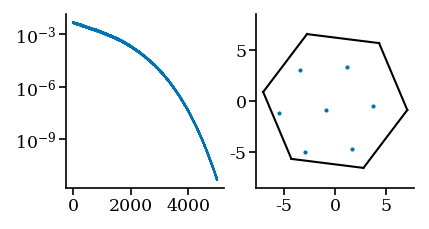

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(3, 1.5))
axs[0].semilogy(loss_history)
ci_model.unit_cell.plot(fig=fig, ax=axs[1], color='black')
axs[1].scatter(*ci_model.phases.detach().numpy().T,s=1)
axs[1].axis('equal')
#ax.axis('off')

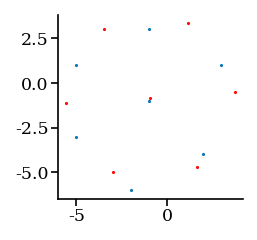

In [44]:
from utils import find_peaks
import torch

rel_box_size = ci_model.unit_cell.radius * res / radius

x = np.linspace(-rel_box_size/2,rel_box_size/2,res)
y = np.linspace(-rel_box_size/2,rel_box_size/2,res)
X,Y = np.meshgrid(x,y)
square_mesh = np.stack([X,Y],axis=-1)
square_mesh.shape

# calculate ratemaps with given resolution and find peaks in the sqaure mesh
ci_ratemaps = ci_model(torch.tensor(square_mesh.reshape(-1,2),
                                    dtype=torch.float32)).detach().numpy().reshape(res,res,-1)
ci_center_peaks = np.array([find_peaks(ci_ratemaps[:,:,i])[0] for i in range(ci_ratemaps.shape[-1])])
# convert peaks to unit cell coordinates again
ci_center_peaks = ci_center_peaks / res * rel_box_size - rel_box_size/2

plt.scatter(*ci_center_peaks.T)
plt.scatter(*ci_model.phases.detach().numpy().T, color='red')

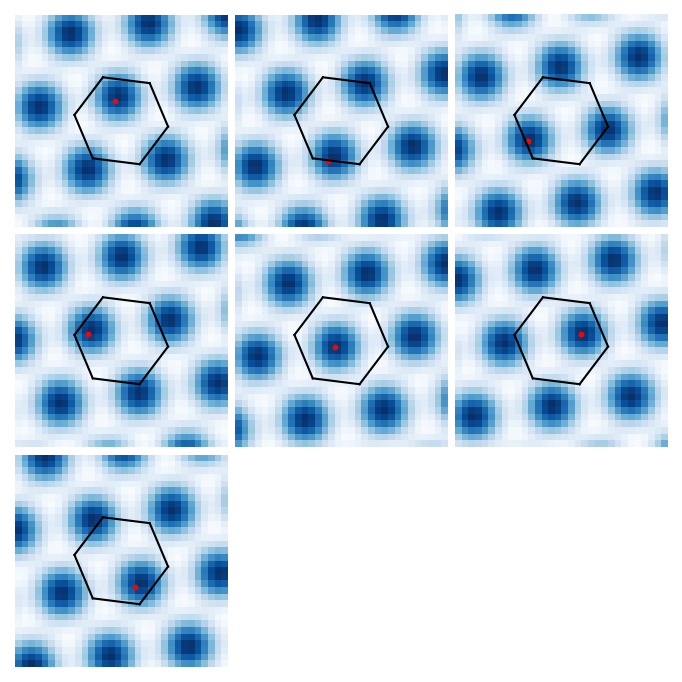

In [45]:
fig, axs = multiimshow(ci_ratemaps.transpose(2,1,0), origin='lower', figsize=(5,5), normalize=False, 
                       extent=(-rel_box_size/2,rel_box_size/2,-rel_box_size/2,rel_box_size/2));
for i in range(len(ci_center_peaks)):
    axs[i].scatter(*ci_center_peaks[i], color='red', s=3)
    ci_model.unit_cell.plot(fig, axs[i], center=np.zeros(2), color='black')

In [46]:
#ci_center_peaks = ci_center_peaks[:,None] + np.random.normal(0, 10, size=(ratemaps.shape[0]//7,2))[None]
ci_center_peaks = ci_model.phases.detach().numpy()[:,None] + np.random.normal(0, 0.2, size=(ratemaps.shape[0]//7,2))[None]
ci_center_peaks = ci_center_peaks.reshape(-1,2)
#ci_center_peaks = np.around(ci_model.unit_cell.wrap(ci_center_peaks))
ci_center_peaks = ci_model.unit_cell.wrap(ci_center_peaks)

ci_center_peaks.shape

(98, 2)

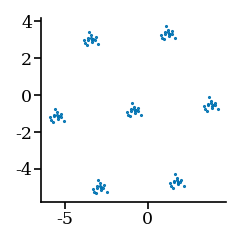

In [47]:
plt.scatter(*ci_center_peaks.T)

In [52]:
radii = np.linspace(0, hexagon.unit_cell.radius-1e-6, 32)[1:]
random_ripleys = []
for _ in tqdm.trange(100):
    random_hexagon.set_phases(np.around(random_hexagon.unit_cell.wrap(random_hexagon.unit_cell.sample(len(center_peaks)))))
    random_ripleys_i = [random_hexagon.ripleys(r) for r in radii]
    random_ripleys.append(random_ripleys_i)
random_ripleys = np.array(random_ripleys)

100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


In [53]:
ripleys = [hexagon.ripleys(r) for r in radii]
ci_ripleys = [ci_model.ripleys(r,phases=ci_center_peaks) for r in radii]
ripleys = np.array(ripleys)

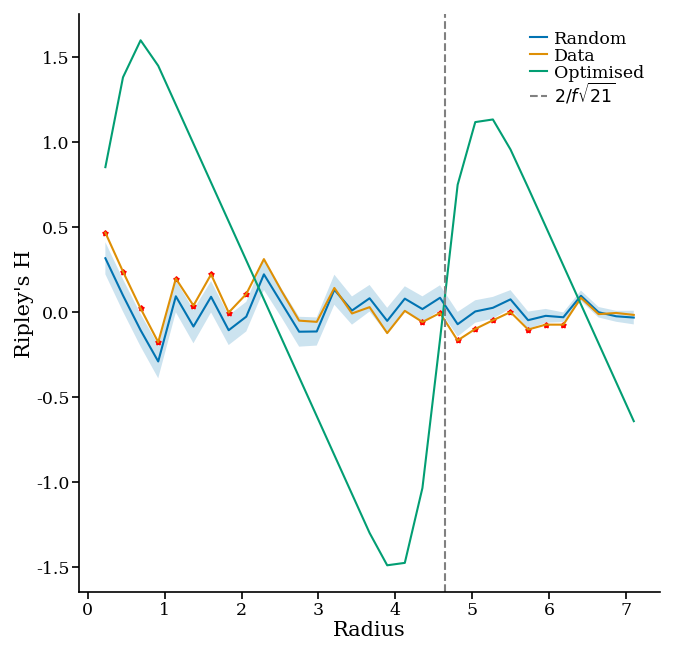

In [54]:
plt.figure(figsize = (5,5))

# random baseline
plt.plot(radii, np.mean(random_ripleys, axis=0), label = "Random")
mu_random = np.mean(random_ripleys, axis=0)
sigma_random = np.std(random_ripleys, axis=0)
plt.fill_between(radii, mu_random - 2*sigma_random, mu_random + 2*sigma_random, alpha=0.2)
# plot star where significant
plt.scatter(radii[ripleys > mu_random + 2*sigma_random], 
            ripleys[ripleys > mu_random + 2*sigma_random], color='red', marker='*', s=5)
plt.scatter(radii[ripleys < mu_random -2*sigma_random], 
            ripleys[ripleys < mu_random-2*sigma_random], color='red', marker='*', s=5)
# data
plt.plot(radii, ripleys, label = "Data")

# hexagonal baseline
plt.plot(radii, ci_ripleys, label = "Optimised")

plt.axvline(2/(ci_model.f*np.sqrt(21)), color='grey', linestyle='--', label=r'$2/f\sqrt{21}$')

plt.xlabel('Radius')
plt.ylabel('Ripley\'s H')
plt.legend(frameon = False)

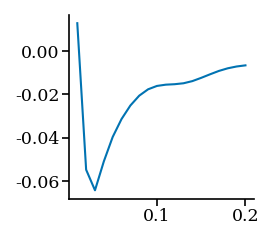

In [51]:
grid_scores = [hexagon.grid_score(bw_method=r) for r in bw_method]
plt.plot(bw_method, grid_scores)

**We want to** find the distance between two neighbouring small hexagons centers, i.e. $2a_p$. This gives us an expectation for when the ripleys would change from below random expectation to above random expectation of phases in a given ball radius, in the scenario where the phases where hexagonally arranged.

We have the frequency of the generating pattern is $f=\frac{2}{3R}$, where $R$ is the radius of the corresponding unit cell. The apothem $A_p$ of the unit cell can be calculated from the special triangle (30-60-90 triangle) with side lengths (from long to short) as $R, A_p, R/2$. This gives

\begin{align}
R^2 &= A_p^2 + \left(\frac{R}{2}\right)^2 \\
A_p  &= \frac{\sqrt{3}}{2}R
\end{align}

We further have that the unit cell can have a good cover with 7 regular hexagons. The area of each of these subhexagons are $a = \frac{1}{7}A$ of the size of the area of the unit cell hexagon. The area of a hexagon is in general given by $A = \frac{3\sqrt(3)R^2}{2}$. So get we

\begin{align}
a &= \frac{1}{7}A \\
\frac{3\sqrt(3)r^2}{2} &= \frac{1}{7} \cdot \frac{3\sqrt(3)R^2}{2} \\
r &= \frac{1}{\sqrt{7}}R
\end{align}

Since $A_p$ is proportional to $R$, we also have $a_p = \frac{1}{\sqrt{7}} A_p$ 

This gives $2a_p$, in terms of $f$

\begin{align}
2a_p = 2\cdot\frac{1}{\sqrt{7}} A_p = \frac{2}{\sqrt{7}}\cdot \frac{\sqrt{3}}{2}R = \frac{\sqrt{3}}{\sqrt{7}}\cdot \frac{2}{3f} = \frac{2}{f\sqrt{21}}
\end{align}